In [103]:
from speech_pause_indicator import speech, pause ; import setup; from setup import make_samples, play_samples, get_word_xy, plot_word, plot_alignment, plt, np, alignment_err

In [111]:
##https://pyts.readthedocs.io/en/stable/auto_examples/metrics/plot_dtw.html
from pyts.datasets import load_gunpoint
from pyts.metrics import dtw, itakura_parallelogram, sakoe_chiba_band
from pyts.metrics.dtw import (cost_matrix, accumulated_cost_matrix,
                              _return_path, _blurred_path_region)
import itertools

In [105]:
# pyts - classic
def classic(x, y, xlabel, ylabel, time1_lst, time2_lst):
    method = 'classic'
    dtw_classic, path_classic = dtw(x, y, dist='square', method=method, return_path=True)
    path = path_classic
    dist = dtw_classic
    plt.figure(figsize=(8, 4.5))                                
    plt.title('dtw' + '_' + method + ' distance: ' + str(dist));
    plt.plot(path[0], path[1]);
    alignment_err(path, file1, file2, seg1_1, seg1_2, seg2_1, seg2_2, time1_lst, time2_lst, xlabel, ylabel)

    # return path, dist

In [106]:
# pyts itakura

def itakura(x, y, xlabel, ylabel, time1_lst, time2_lst):

    method = 'itakura'
    slope = 1.2
    dtw_itakura, path_itakura = dtw(
        x, y, dist='square', method='itakura',
        options={'max_slope': slope}, return_path=True
    )
    parallelogram = itakura_parallelogram(n_timestamps_1, n_timestamps_2,
                                          max_slope=slope)
    matrix_itakura = np.zeros((n_timestamps_1 + 1, n_timestamps_2 + 1))
    for i in range(n_timestamps_1):
        matrix_itakura[i, np.arange(*parallelogram[:, i])] = 0.5
    matrix_itakura[tuple(path_itakura)] = 1.
    plt.figure(figsize=(8, 4.5))          
    path = path_itakura
    dist = dtw_itakura
    
    plt.plot(path[0], path[1]);

    plt.title('dtw' + '_' + method + ' distance: ' + str(dist));
    alignment_err(path, file1, file2, seg1_1, seg1_2, seg2_1, seg2_2, time1_lst, time2_lst, xlabel, ylabel);
    
    #return path, dist

In [107]:
# pyts sakoechiba

def sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst):
    method = "sakoechiba"
    window_size = 0.1
    dtw_sakoechiba, path_sakoechiba = dtw(
        x, y, dist='square', method='sakoechiba',
        options={'window_size': window_size}, return_path=True
    )
    band = sakoe_chiba_band(n_timestamps_1, n_timestamps_2,
                            window_size=window_size)
    matrix_sakoechiba = np.zeros((n_timestamps_1 + 1, n_timestamps_2 + 1))
    for i in range(n_timestamps_1):
        matrix_sakoechiba[i, np.arange(*band[:, i])] = 0.5
    matrix_sakoechiba[tuple(path_sakoechiba)] = 1.

    path = path_sakoechiba
    dist = dtw_sakoechiba
    
    plt.figure(figsize=(8, 4.5))             ; plt.title('dtw' + '_' + method + ' distance: ' + str(dist));
    plt.plot(path[0], path[1]);
    alignment_err(path, file1, file2, seg1_1, seg1_2, seg2_1, seg2_2, time1_lst, time2_lst, xlabel, ylabel)
    
    # return path, dist

In [108]:
def multiscale(x, y, xlabel, ylabel, time1_lst, time2_lst):
    method = "multiscale"

    resolution, radius = 5, 2
    dtw_multiscale, path_multiscale = dtw(
        x, y, dist='square', method='multiscale',
        options={'resolution': resolution, 'radius': radius}, return_path=True
    )

    x_padded = x.reshape(-1, resolution).mean(axis=1)
    y_padded = y.reshape(-1, resolution).mean(axis=1)

    cost_mat_res = cost_matrix(x_padded, y_padded, dist='square', region=None)
    acc_cost_mat_res = accumulated_cost_matrix(cost_mat_res)
    path_res = _return_path(acc_cost_mat_res)

    multiscale_region = _blurred_path_region(
        n_timestamps_1, n_timestamps_2, resolution, x_padded.size, y_padded.size,
        path_res,
        radius=radius
    )
    matrix_multiscale = np.zeros((n_timestamps_1 + 1, n_timestamps_2 + 1))
    for i in range(n_timestamps_1):
        matrix_multiscale[i, np.arange(*multiscale_region[:, i])] = 0.5
    matrix_multiscale[tuple(path_multiscale)] = 1.

    path = path_multiscale
    dist = dtw_multiscale
    
    plt.figure(figsize=(8, 4.5)); plt.title('dtw' + '_' + method + ' distance: ' + str(dist));
    plt.plot(path[0], path[1]);
    alignment_err(path, file1, file2, seg1_1, seg1_2, seg2_1, seg2_2, time1_lst, time2_lst, xlabel, ylabel)
    
    # return path, dist

In [109]:
def alignment_err(path, file1, file2, seg1_1, seg1_2, seg2_1, seg2_2, time1_lst, time2_lst, xlabel, ylabel):
    colors = ['red', 'g', 'b', 'm', 'brown', '#d89743', 'grey', 'c', 'orange', 'g', 'b', 'm', 'red']
    err = 0
    for i in range(len(time1_lst)):
        x_axis = get_word_xy(file1, time1_lst[i], seg1_1, seg1_2)
        y_axis = get_word_xy(file2, time2_lst[i], seg2_1, seg2_2)
        
        plt.axvline(x_axis, color = colors[i])
        plt.hlines(y_axis, 0, x_axis+6000, color = colors[i])
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        
        x_val = list(itertools.chain(*np.where(np.abs(path[0] - x_axis) < 0.1)))[0]
        y_val = list(itertools.chain(*np.where(np.abs(path[1] - y_axis) < 0.1)))[0]

        warp_y = path[1][x_val]
        warp_x = path[0][y_val]
        
        e = np.abs(warp_x - x_axis) + np.abs(warp_y - y_axis)
        err = err + e
    print('Avg err: ' + str(err/len(time1_lst)))

# TORGO: Except in the winter

In [133]:
file1, seg1_1, seg1_2 = "torgo-healthy.wav", 2, 3.7
file2, seg2_1, seg2_2 = "torgo-patient.wav", 2.5, 4.7

x, y, samplerate = setup.make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2)
n_timestamps_1, n_timestamps_2 = x.size, y.size

xlabel = "Except in the winter - healthy" ;  ylabel = "Except in the winter - patient"
time1_lst = [2.34, 2.86, 3.03, 3.17] ; time2_lst = [2.8, 3.85, 4.03, 4.20]


Avg err: 6514.750000000002


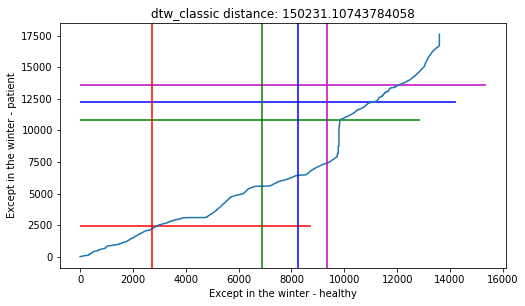

In [134]:
classic(x, y, xlabel, ylabel, time1_lst, time2_lst)

Avg err: 699.5000000000019


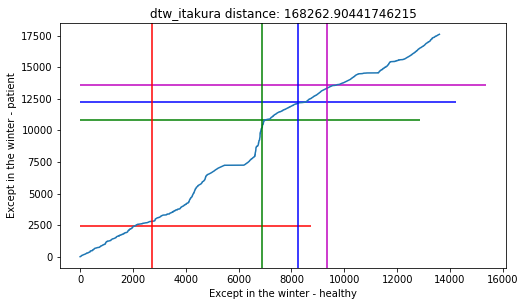

In [135]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst)

Avg err: 3397.500000000002


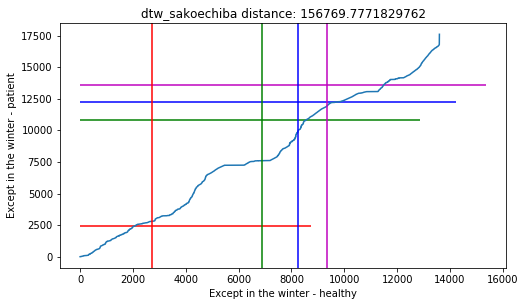

In [136]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst)

Avg err: 4480.000000000002


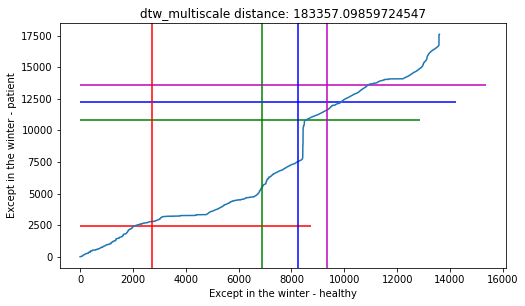

In [137]:
multiscale(x, y, xlabel, ylabel, time1_lst, time2_lst)

# Torgo: when the ooze or snow or ice presents

In [126]:
file1, seg1_1, seg1_2 = "torgo-healthy.wav", 3.7, 6.50
file2, seg2_1, seg2_2 = "torgo-patient.wav", 4.75, 11.38
x, y, samplerate = setup.make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2)
n_timestamps_1, n_timestamps_2 = x.size, y.size
time1_lst = [3.94, 4.03, 4.38, 4.8, 5.1, 5.54, 5.73, 6.18] ;
time2_lst = [7.07, 7.26, 7.78, 8.21, 8.53, 9.57, 9.9, 10.76]
xlabel = "Healthy: when the ooze or snow or ice presents" ;  ylabel = "patient"

Avg err: 3324.1250000000014


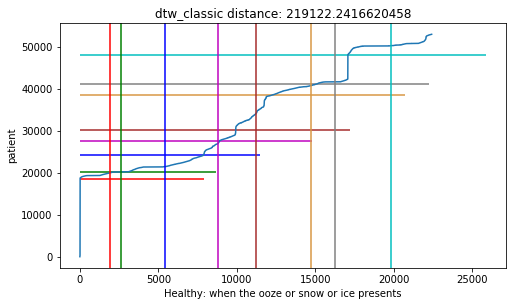

In [128]:
classic(x, y, xlabel, ylabel, time1_lst, time2_lst)

Avg err: 9626.75


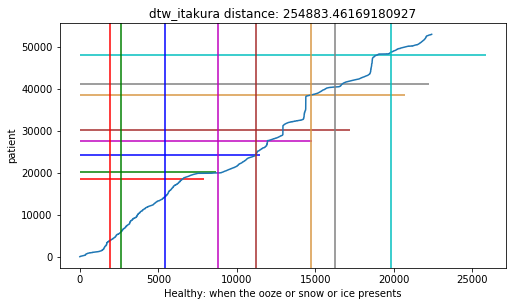

In [130]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst)

Avg err: 8442.75


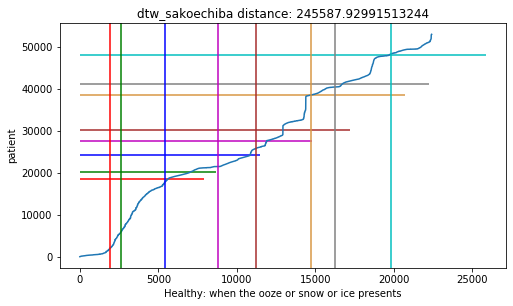

In [131]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst)

Avg err: 4976.625000000002


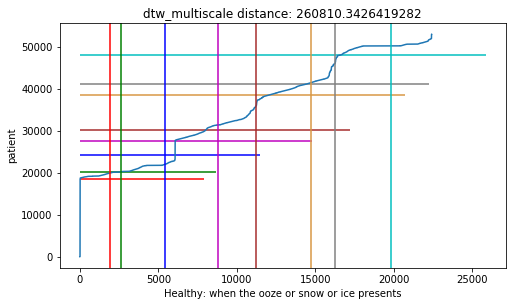

In [132]:
multiscale(x, y, xlabel, ylabel, time1_lst, time2_lst)

# Bamboo - perfect alignment - Normal v.s. Normal 01 vs. 01_1

In [121]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 5.8
file2, seg2_1, seg2_2 = "01_1.wav", 2, 4.1
x, y, samplerate = setup.make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2)
n_timestamps_1, n_timestamps_2 = x.size, y.size
xlabel = "Bamboo walls are getting to be very popular - Normal 1" ;  ylabel = "Normal 01_1"
time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] ;
time2_lst = [2.33, 2.63, 2.87, 3.12, 3.4, 3.57, 3.74, 4.06]

Avg err: 1293.25


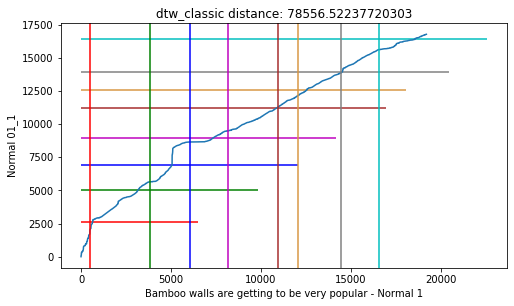

In [122]:
classic(x, y, xlabel, ylabel, time1_lst, time2_lst)

Avg err: 3701.2500000000005


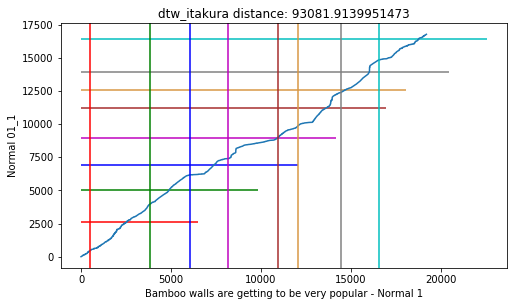

In [123]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst)

Avg err: 1522.5000000000014


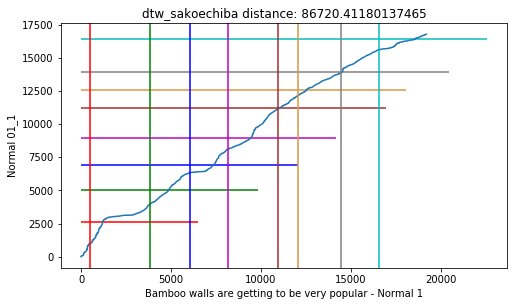

In [124]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst)

Avg err: 782.2499999999989


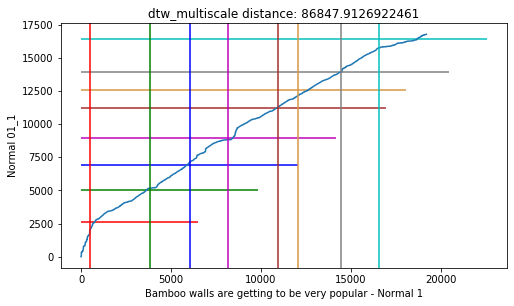

In [125]:
multiscale(x, y, xlabel, ylabel, time1_lst, time2_lst)

# Bamboo - perfect alignment - Normal v.s. Normal 01 vs. 01_2

In [116]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 5.8
file2, seg2_1, seg2_2 = "01_2.wav", 2, 4.15
x, y, samplerate = setup.make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2)
n_timestamps_1, n_timestamps_2 = x.size, y.size

xlabel = "Bamboo walls are getting to be very popular - Normal 01" ;  ylabel = "Normal 01_2"
time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] ;
time2_lst = [2.28, 2.72, 2.93, 3.18, 3.51, 3.66, 3.84, 4.11]

Avg err: 1883.9999999999982


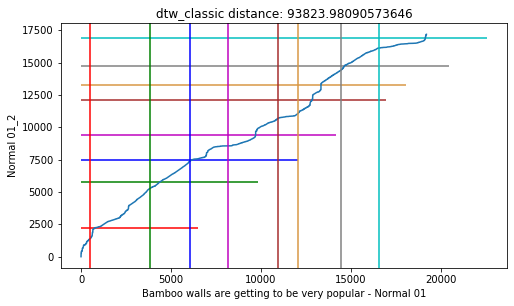

In [117]:
classic(x, y, xlabel, ylabel, time1_lst, time2_lst)

Avg err: 4682.374999999998


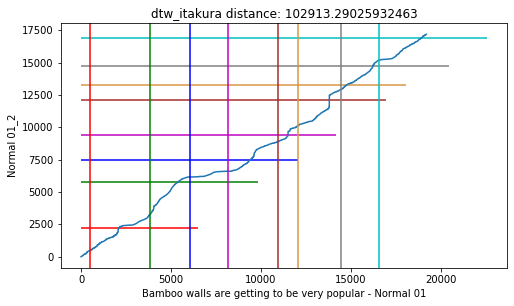

In [118]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst)

Avg err: 2544.499999999998


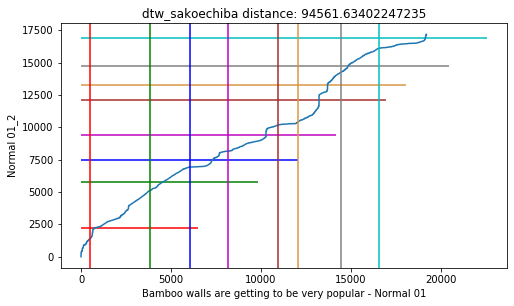

In [119]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst)

Avg err: 2366.874999999998


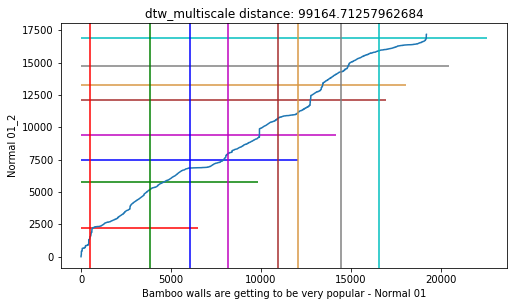

In [120]:
multiscale(x, y, xlabel, ylabel, time1_lst, time2_lst)

# Bamboo - perfect alignment - Normal v.s. Normal 01 vs. 01_3

In [73]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 5.8
file2, seg2_1, seg2_2 = "01_3.wav", 2, 4
x, y, samplerate = setup.make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2)
n_timestamps_1, n_timestamps_2 = x.size, y.size

xlabel = "Bamboo walls are getting to be very popular - Normal 1" ;  ylabel = "Normal 01_3"
time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] ;
time2_lst = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];

Avg err: 1024.8749999999998


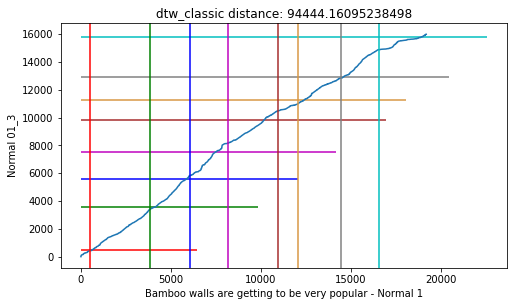

In [76]:
classic(x, y, xlabel, ylabel, time1_lst, time2_lst)

Avg err: 1257.8749999999998


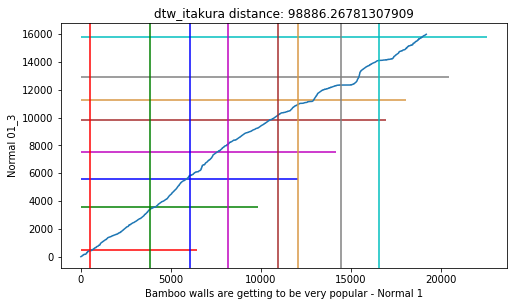

In [112]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst)

Avg err: 1024.8749999999998


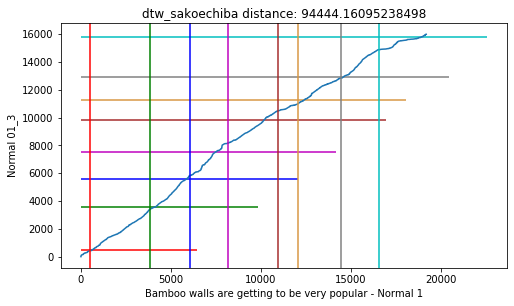

In [113]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst)

Avg err: 1119.0000000000002


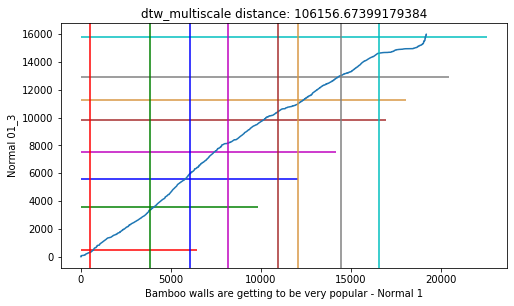

In [93]:
multiscale(x, y, xlabel, ylabel, time1_lst, time2_lst)

# Bamboo - perfect alignment - Normal v.s. Normal 01_2 vs. 01_3

In [142]:
file1, seg1_1, seg1_2 = "01_2.wav", 2, 4.15
file2, seg2_1, seg2_2 = "01_3.wav", 2, 4
x, y, samplerate = setup.make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2)
n_timestamps_1, n_timestamps_2 = x.size, y.size

xlabel = "Bamboo walls are getting to be very popular - Normal 01_2" ;  ylabel = "Normal 01_3"

time1_lst = [2.28, 2.72, 2.93, 3.18, 3.51, 3.66, 3.84, 4.11]
time2_lst = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];

Avg err: 4999.874999999998


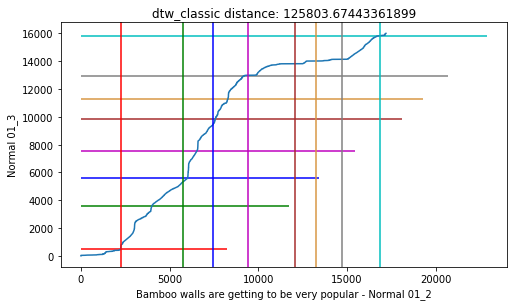

In [143]:
classic(x, y, xlabel, ylabel, time1_lst, time2_lst)

Avg err: 2875.874999999998


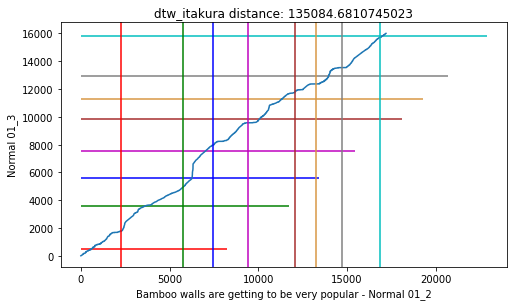

In [144]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst)

Avg err: 1653.9999999999982


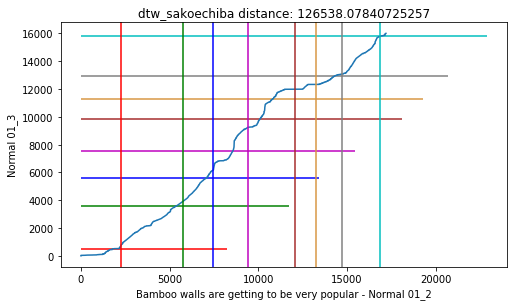

In [145]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst)

Avg err: 2284.999999999998


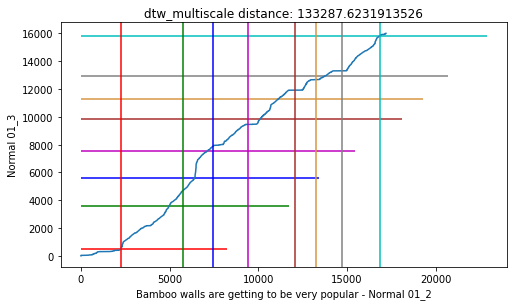

In [146]:
multiscale(x, y, xlabel, ylabel, time1_lst, time2_lst)

# Bamboo - perfect alignment - Normal v.s. Normal 01_1 vs. 01_2

In [152]:
file1, seg1_1, seg1_2 = "01_1.wav", 2, 4.1
file2, seg2_1, seg2_2 = "01_2.wav", 2, 4.15
x, y, samplerate = setup.make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2)
n_timestamps_1, n_timestamps_2 = x.size, y.size
time1_lst = [2.33, 2.63, 2.87, 3.12, 3.4, 3.57, 3.74, 4.06]
time2_lst = [2.28, 2.72, 2.93, 3.18, 3.51, 3.66, 3.84, 4.11]

xlabel = "Bamboo walls are getting to be very popular - Normal 01_1" ;  ylabel = "Normal 01_2"

Avg err: 5454.374999999997


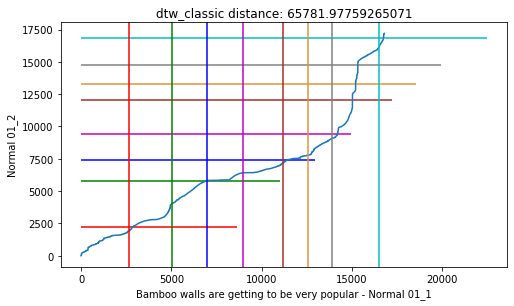

In [153]:
classic(x, y, xlabel, ylabel, time1_lst, time2_lst)

Avg err: 869.1249999999976


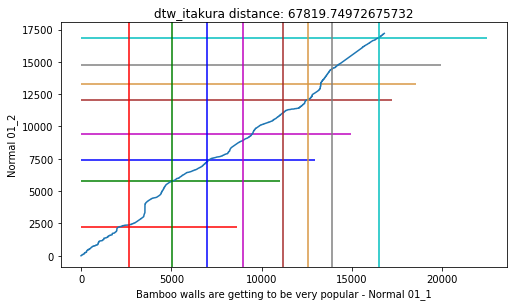

In [154]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst)

Avg err: 859.6249999999994


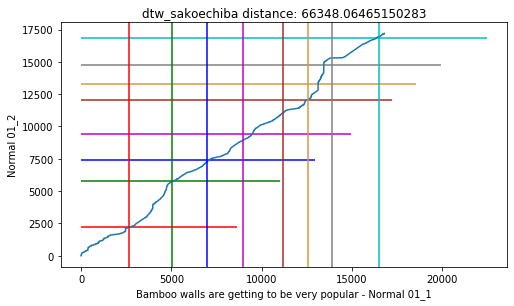

In [155]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst)

Avg err: 960.2499999999969


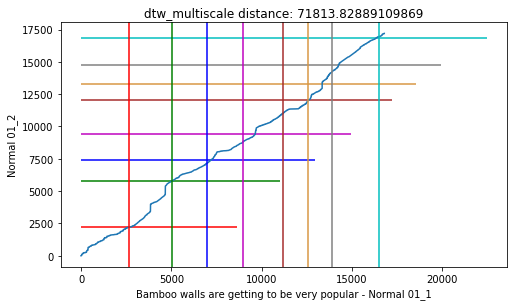

In [156]:
multiscale(x, y, xlabel, ylabel, time1_lst, time2_lst)

# Bamboo - perfect alignment - Normal v.s. Normal 01_1 vs. 01_3

In [157]:
file1, seg1_1, seg1_2 = "01_1.wav", 2, 4.1
file2, seg2_1, seg2_2 = "01_3.wav", 2, 4

x, y, samplerate = setup.make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2)
n_timestamps_1, n_timestamps_2 = x.size, y.size
time1_lst = [2.33, 2.63, 2.87, 3.12, 3.4, 3.57, 3.74, 4.06]
time2_lst = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];
xlabel = "Bamboo walls are getting to be very popular - Normal 01_1" ;  ylabel = "Normal 01_3"

Avg err: 435.3750000000007


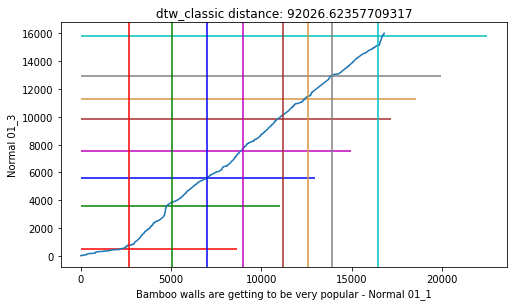

In [158]:
classic(x, y, xlabel, ylabel, time1_lst, time2_lst)

Avg err: 876.3750000000007


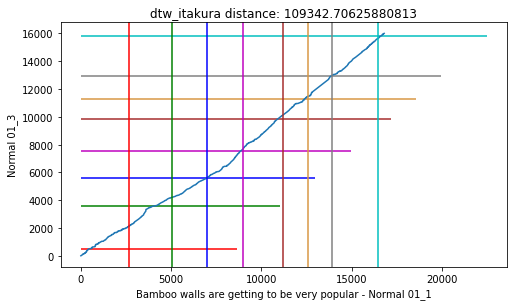

In [159]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst)

Avg err: 592.2500000000007


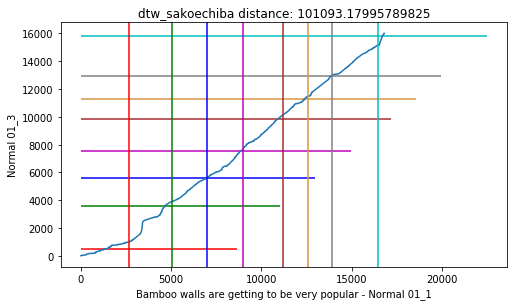

In [160]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst)

Avg err: 458.0000000000009


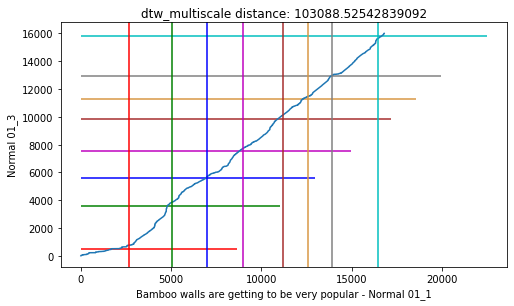

In [161]:
multiscale(x, y, xlabel, ylabel, time1_lst, time2_lst)